In [1]:
!nvidia-smi

Tue Jan 19 08:00:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/My Drive/AOI') #切換該目錄
os.listdir() #確認目錄內容

['test_images.zip',
 'classify',
 'Model.h5',
 'test_images',
 'csv',
 'Model_Predict.ipynb',
 'QC_Sampling.ipynb',
 'QC_Diff_of_Predictions.ipynb',
 'TL_VGG16',
 'Model.ipynb',
 'VGG16-valAcc9594.h5',
 'VGG16-valAcc9683.h5',
 'QC_toCSV.ipynb',
 'TL_InceptionV3',
 'VGG16-valAcc9286.h5',
 'InceptionV3.h5',
 'image_compare.ipynb',
 'VGG16.ipynb',
 'InceptionV3.ipynb']

In [4]:
# input 為 灰階 256 * 256 圖像
# 灰階 為 1 通道
input_shape = (256, 256, 3)

# Model building

In [5]:
from tensorflow.python.keras.applications.vgg16 import VGG16

# transfer trainging
# need not to include the output layer, we will redefine it later
vgg16 = VGG16(include_top=False, input_shape=input_shape)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

def build_model(vgg16):
    model = Sequential(vgg16.layers)

    for layer in model.layers[:15]:
        layer.trainable = False
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    # redefine the output layer to 6 class(AOI )
    model.add(Dense(6, activation='sigmoid'))

    return model

In [7]:
model = build_model(vgg16)

In [8]:
from keras.optimizers import Adam

model.compile(
    loss = 'categorical_crossentropy',
    # optimizer=SGD(lr=1e-4, momentum=0.9),
    optimizer=Adam(lr=1e-4),
    metrics=['categorical_accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       2

# pre

In [9]:
# 將輸入圖片擴張
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    width_shift_range=1.0,
    height_shift_range=1.0,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split = 0.2
)

In [10]:
# 產生迭代器
img_itr_train = train_datagen.flow_from_directory(
    './classify',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

img_itr_valid = train_datagen.flow_from_directory(
    './classify',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 4047 images belonging to 6 classes.
Found 1009 images belonging to 6 classes.


# Callback

In [11]:
from datetime import datetime

model_dir = os.path.join(
    'TL_VGG16',
    datetime.now().strftime('%y%m%d_%H%M')
)
os.makedirs(model_dir, exist_ok=True)

dir_weights = os.path.join(model_dir, 'weights')
os.makedirs(dir_weights, exist_ok=True)

In [12]:
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# ModelCheckpoint
cp_filepath = os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{val_categorical_accuracy:.2f}.h5')
cp = ModelCheckpoint(
    cp_filepath,
    monitor='val_categorical_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

# CSVLogger
csv_filepath = os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

# EarlyStopping
estop = EarlyStopping(
    monitor='val_categorical_accuracy',
    # min_delta=0.0001,
    patience=32, 
    verbose=1,
    mode='auto'
    # restore_best_weights=False
)

# Trainging

In [13]:
import math

# 計算幾個批次為一次學習
batch_size = 64
steps_per_epoch = math.ceil(
    img_itr_train.samples/batch_size
)
validation_steps = math.ceil(
    img_itr_valid.samples/batch_size
)

In [14]:
history = model.fit_generator(
    img_itr_train,
    steps_per_epoch=steps_per_epoch,
    epochs=500,
    validation_data=img_itr_valid,
    validation_steps=validation_steps,
    callbacks=[cp, csv, estop]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
64/64 [==============================] - 87s 1s/step - loss: 0.9881 - categorical_accuracy: 0.6223 - val_loss: 0.6482 - val_categorical_accuracy: 0.7304

Epoch 00001: val_categorical_accuracy improved from -inf to 0.73043, saving model to TL_VGG16/210119_0800/weights/ep_01_ls_0.73.h5
Epoch 2/500
64/64 [==============================] - 78s 1s/step - loss: 0.3799 - categorical_accuracy: 0.8609 - val_loss: 0.4631 - val_categorical_accuracy: 0.8285

Epoch 00002: val_categorical_accuracy improved from 0.73043 to 0.82854, saving model to TL_VGG16/210119_0800/weights/ep_02_ls_0.83.h5
Epoch 3/500
64/64 [==============================] - 78s 1s/step - loss: 0.2976 - categorical_accuracy: 0.8961 - val_loss: 0.3848 - val_categorical_accuracy: 0.8503

Epoch 00003: val_categorical_accuracy improved from 0.82854 to 0.85035, saving model to TL_VGG16/210119_0800/weights/ep_03_ls_0.85.h5
Epoch 4/500
64/64 [==============================] - 77s 1s/step - loss: 0.2622 - categorical_accuracy:

In [15]:
model.save('VGG16.h5')

from google.colab import files
# files.download('Transfer_Training.h5')

# Review

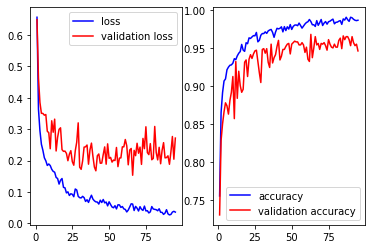

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
acc = history.history['categorical_accuracy']
epochs = range(1, len(loss)+1)
val_loss = history.history['val_loss']
val_acc = history.history['val_categorical_accuracy']

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(epochs, loss, 'b', label='loss')
ax[0].plot(epochs, val_loss, 'r', label='validation loss')
ax[0].legend()
ax[1].plot(epochs, acc, 'b', label='accuracy')
ax[1].plot(epochs, val_acc, 'r', label='validation accuracy')
ax[1].legend()
plt.show()

# Valid

In [17]:
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

evaluate_itr = valid_datagen.flow_from_directory(
    './classify',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate_generator(evaluate_itr)
print(f'loss = {loss:.2f}')
print(f'accuracy = {accuracy:.2f}')

Found 5056 images belonging to 6 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss = 0.11
accuracy = 0.97


In [20]:
import numpy as np

# labels
labels = evaluate_itr.class_indices

# then use predict_geneorator to predict the result base on model
evaluate_itr.reset()
pred = model.predict_generator(evaluate_itr, verbose=1)

# prediction from model
predicted_class_indices = np.argmax(pred, axis=1)
# real results in training set
true_label= evaluate_itr.classes

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


79/79 [==============================] - 25s 316ms/step


In [21]:
#使用pd.crosstab来简单画出混淆矩阵
import pandas as pd

table = pd.crosstab(predicted_class_indices, true_label,colnames=['predict'], rownames=['label'])
table

predict,0,1,2,3,4,5
label,,,,,,
0,1248,4,29,1,0,0
1,1,965,0,19,7,0
2,2,0,170,0,0,0
3,97,10,1,735,32,8
4,0,1,0,1,441,0
5,0,4,0,0,0,1280
